# Meta-Sampling: Estratégia de seleção de instâncias baseada em meta-aprendizado

## Imports

In [1]:
import warnings 

import pandas as pd 
import numpy as np

## Elaboração de meta-base 

In [2]:
DATA_DIR = '../../metabase/'

Metafeatures (não supervisionadas) que serão utilizadas para o método:

In [3]:
meta_features = ['attr_conc.mean', 'attr_conc.sd', 'attr_ent.mean', 'attr_ent.sd', 'attr_to_inst', 'cat_to_num', 'cohesiveness.mean', 
                 'cohesiveness.sd', 'cor.mean', 'cor.sd', 'cov.mean', 'cov.sd', 'eigenvalues.mean', 'eigenvalues.sd', 'g_mean.mean', 'g_mean.sd',
                 'h_mean.mean', 'h_mean.sd', 'inst_to_attr', 'iq_range.mean', 'iq_range.sd', 'kurtosis.mean', 'kurtosis.sd', 'mad.mean', 'mad.sd'
                 , 'max.mean', 'max.sd', 'mean.mean', 'mean.sd', 'median.mean', 'median.sd', 'min.mean', 'min.sd', 'nr_attr', 'nr_bin', 'nr_cat',
                 'nr_cor_attr', 'nr_inst', 'nr_norm', 'nr_num', 'nr_outliers', 'num_to_cat', 'one_itemset.mean', 'one_itemset.sd', 'range.mean', 
                 'range.sd', 'sd.mean', 'sd.sd', 'skewness.mean', 'skewness.sd', 'sparsity.mean', 'sparsity.sd', 't2', 't3', 't4', 't_mean.mean',
                 't_mean.sd', 'two_itemset.mean', 'two_itemset.sd', 'var.mean', 'var.sd', 'wg_dist.mean', 'wg_dist.sd']

In [4]:
metrics = ['accuracy', 'f1-micro', 'f1-macro', 'f1-weighted']

In [5]:
%%time
import os
import numpy as np
import pandas as pd

csv_files =  [file for file in os.listdir(DATA_DIR) if file.endswith('csv')]
df_list = [pd.read_csv(os.path.join(DATA_DIR, file), index_col=False) for file in csv_files]

CPU times: user 5.08 s, sys: 707 ms, total: 5.79 s
Wall time: 5.93 s


Juntando dataframes:

In [6]:
columns = ['estimator', 'query-strategy'] + metrics + meta_features 
df = pd.concat(df_list, keys=csv_files)
df = df[columns]
df.index.names=['dataset', 'index']

Adicionando a informação referente à query:

In [7]:
def add_query_index(x):
    x['query_index']=range(len(x))
    return x
df = df.groupby(['dataset','estimator', 'query-strategy'], group_keys=False).apply(add_query_index)

Rotulando qual melhor estratégia para cada tripla `(dataset, estimator, query_index)` com base na acurácia:

In [8]:
meta_base = df.groupby(['dataset','estimator','query_index'], group_keys=True).apply(lambda x: x.loc[x['accuracy'].idxmax()])
meta_base.drop(['estimator', 'query_index'] + metrics, axis=1, inplace=True)

In [9]:
meta_base

query-strategy  \
dataset        estimator              query_index                         
1005_glass.csv DecisionTreeClassifier 0            uncertainty_sampling   
                                      1                 margin_sampling   
                                      2                 margin_sampling   
                                      3                 margin_sampling   
                                      4                entropy_sampling   
...                                                                 ...   
991_car.csv    SVCLinear              95                margin_sampling   
                                      96                margin_sampling   
                                      97                margin_sampling   
                                      98                margin_sampling   
                                      99           uncertainty_sampling   

                                                   attr_conc.mean  \
dataset        estimator              query_index                   
1005_glass.csv DecisionTreeClassifier 0                  0.082414   
                                      1                  0.081938   
                                      2                  0.083475   
                                      3                  0.084567   
                                      4                  0.091017   
...                                                           ...   
991_car.csv    SVCLinear              95                 0.021034   
                                      96                 0.027452   
                                      97                 0.024350   
                                      98                 0.023121   
                                      99                 0.017146   

                                                   attr_conc.sd  \
dataset        estimator              query_index                 
1005_glass.csv DecisionTreeClassifier 0                0.064700   
                                      1                0.061594   
                                      2                0.062401   
                                      3                0.059189   
                                      4                0.066402   
...                                                         ...   
991_car.csv    SVCLinear              95               0.058361   
                                      96               0.070061   
                                      97               0.062404   
                                      98               0.059174   
                                      99               0.044504   

                                                   attr_ent.mean  attr_ent.sd  \
dataset        estimator              query_index                               
1005_glass.csv DecisionTreeClassifier 0                 2.013577     0.628029   
                                      1                 2.010002     0.636588   
                                      2                 2.010450     0.635328   
                                      3                 2.012189     0.632815   
                                      4                 2.015954     0.625010   
...                                                          ...          ...   
991_car.csv    SVCLinear              95                0.847737     0.063479   
                                      96                0.847793     0.063381   
                                      97                0.847837     0.063279   
                                      98                0.847787     0.063222   
                                      99                0.847080     0.063511   

                                                   attr_to_inst  cat_to_num  \
dataset        estimator              query_index                             
1005_glass.csv DecisionTreeClassifier 0                0.058824         0.0   
                    

Fazendo download do arquivo:

In [10]:
meta_base.to_csv('metabase.csv')

## Treinamento de Meta-Modelo

In [11]:
meta_base =  pd.read_csv('metabase.csv', index_col=['dataset', 'estimator', 'query_index'])

Substituindo valores infinitos por `np.nan`

In [12]:
meta_base.replace([np.inf, -np.inf], np.nan, inplace=True)

Separando uma base para teste e o restante para treinamento (LOO)

In [13]:
train_index = meta_base.index.levels[0][:-1]
test_index = meta_base.index.levels[0][-1:]

len(train_index), len(test_index)

(87, 1)

Separando features e rótulos (utilizando apenas o classificador SVM)

In [14]:
train_data = meta_base.loc[train_index].xs("SVC", level='estimator').reset_index()
test_data = meta_base.loc[test_index].xs("SVC", level='estimator').reset_index()

Separando conjuntos em treino e teste

In [15]:
X_train = train_data.drop(columns=['dataset', 'query-strategy', 'query_index'])
y_train = train_data['query-strategy']

X_test = test_data.drop(columns=['dataset', 'query-strategy', 'query_index'])
y_test = test_data['query-strategy']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6508, 63) (6508,)
(100, 63) (100,)


Induzindo modelo

In [16]:
import numpy as np 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline



clf = Pipeline([
    ('mean_inputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('meta-model', RandomForestClassifier())
])

clf.fit(X_train.values, y_train)

Pipeline(steps=[('mean_inputer', SimpleImputer()),
                ('meta-model', RandomForestClassifier())])

In [17]:
import pickle as pkl

with open('meta_model.pkl', 'wb') as f:
    pkl.dump(clf, f)

## Implementando Meta-sampling

Sampling strategy utilizada:

In [18]:
from modAL.batch import uncertainty_batch_sampling
from modAL.disagreement import consensus_entropy_sampling, max_disagreement_sampling, vote_entropy_sampling
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
from pymfe.mfe import MFE

def meta_sampling(classifier, X_pool, n_instances):
    query_strategies = {
        'consensus_entropy_sampling': consensus_entropy_sampling,
        'entropy_sampling': entropy_sampling,
        'margin_sampling': margin_sampling,
        'max_disagreement_sampling': max_disagreement_sampling,
        'uncertainty_batch_sampling': uncertainty_batch_sampling,
        'uncertainty_sampling': uncertainty_sampling,
        'vote_entropy_sampling': vote_entropy_sampling
    }

    # carregando modelo
    with open('meta_model.pkl', 'rb') as f:
        model = pkl.load(f)

    # extração de metafeatures
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        mfe = MFE(groups='all')
        mfe.fit(X_pool)
        names, mfts = mfe.extract()

    X = [mfts]

    selected_strategy = query_strategies[model.predict(X)[0]]

    return selected_strategy(classifier, X_pool, n_instances=n_instances)

/home/gabriel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
%load_ext autoreload
%autoreload 2

from active_learning import ActiveLearningExperiment


dataset_id = int(test_index[0].split('_')[0])

exp = ActiveLearningExperiment(dataset_id=dataset_id,
                               random_state=42,
                               l_size=5)

## Comparando Estratégias

Estratégias padrão que serão comparadas:

In [50]:
from modAL import uncertainty as u, disagreement as d, batch as b

query_strategies = {
   'Uncertainty Sampling': u.uncertainty_sampling,
   'Entropy Sampling': u.entropy_sampling,
   'Margin Sampling': u.margin_sampling,
   'Uncertainty Batch Sampling': b.uncertainty_batch_sampling,
   'Consensus Entropy Sampling': d.consensus_entropy_sampling,
   'Vote Entropy Sampling': d.vote_entropy_sampling,
   'Max Disagreement Sampling': d.max_disagreement_sampling
}

Definindo parâmetros

In [54]:
COMMITTEE_SIZE = 3
BATCH_SIZE = 5
N_LABELED_START = 5
RADOM_STATE = 42

Separando cojunto de teste:

In [55]:
from active_learning import ActiveLearningExperiment

dataset_id = test_index[0].split('_')[0]
exp = ActiveLearningExperiment(dataset_id=dataset_id,
                               l_size=N_LABELED_START,
                               random_state=RADOM_STATE)

print('Conjunto de treino:', exp.X_train.shape, f'[|L| = {len(exp.labeled_index)}]')
print('Conjunto de teste:',exp.X_test.shape)

Conjunto de treino: (1296, 21) [|L| = 7]
Conjunto de teste: (432, 21)


Testando as estratégias

In [59]:
from sklearn.svm import SVC
from tqdm import tqdm

metrics_dict = dict()
for name, strategy in tqdm(query_strategies.items()):
    metrics_dict[name] =  exp.run(estimator=SVC(probability=True),
                                  query_strategy=strategy,
                                  committee_size=COMMITTEE_SIZE,
                                  batch_size=BATCH_SIZE)




  0%|                                                                                                   | 0/7 [00:00<?, ?it/s]


 14%|█████████████                                                                              | 1/7 [00:02<00:13,  2.18s/it]


 29%|██████████████████████████                                                                 | 2/7 [00:04<00:10,  2.14s/it]


 43%|███████████████████████████████████████                                                    | 3/7 [00:06<00:08,  2.13s/it]


 57%|████████████████████████████████████████████████████                                       | 4/7 [00:27<00:28,  9.53s/it]


 71%|█████████████████████████████████████████████████████████████████                          | 5/7 [00:33<00:16,  8.33s/it]


 86%|██████████████████████████████████████████████████████████████████████████████             | 6/7 [00:37<00:06,  6.97s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████

Testando método proposto

In [61]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    scores_meta_sampling = exp.run(estimator=SVC(probability=True),
                                   query_strategy=meta_sampling,
                                   committee_size=COMMITTEE_SIZE,
                                   batch_size=BATCH_SIZE)

In [69]:
metrics_dict['Meta-sampling'] = scores_meta_sampling

Estabelecendo um *topline* baseado em uma estratégia "perfeita" utilizando a melhor estratégia possível

In [71]:
metrics_dict['Perfect Meta-sampling'] = exp.run_topline(estimator=SVC(probability=True),
                                                        query_strategies=query_strategies.values(),
                                                        batch_size=BATCH_SIZE,
                                                        committee_size=COMMITTEE_SIZE,
                                                        n_queries=100)


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


In [90]:
styles = ['-']*5 + ['s-', '--']

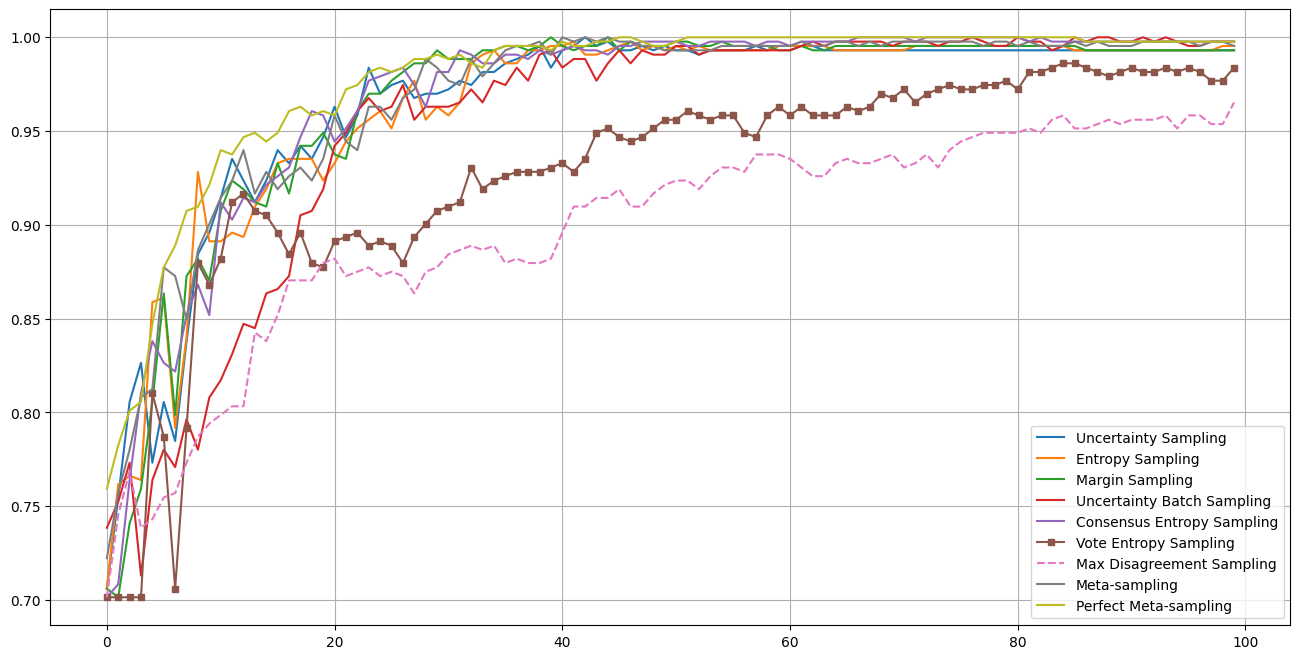

In [91]:
ax = pd.DataFrame(metrics_dict).plot(grid=True, markersize=5,style=styles,  figsize=(16,8))

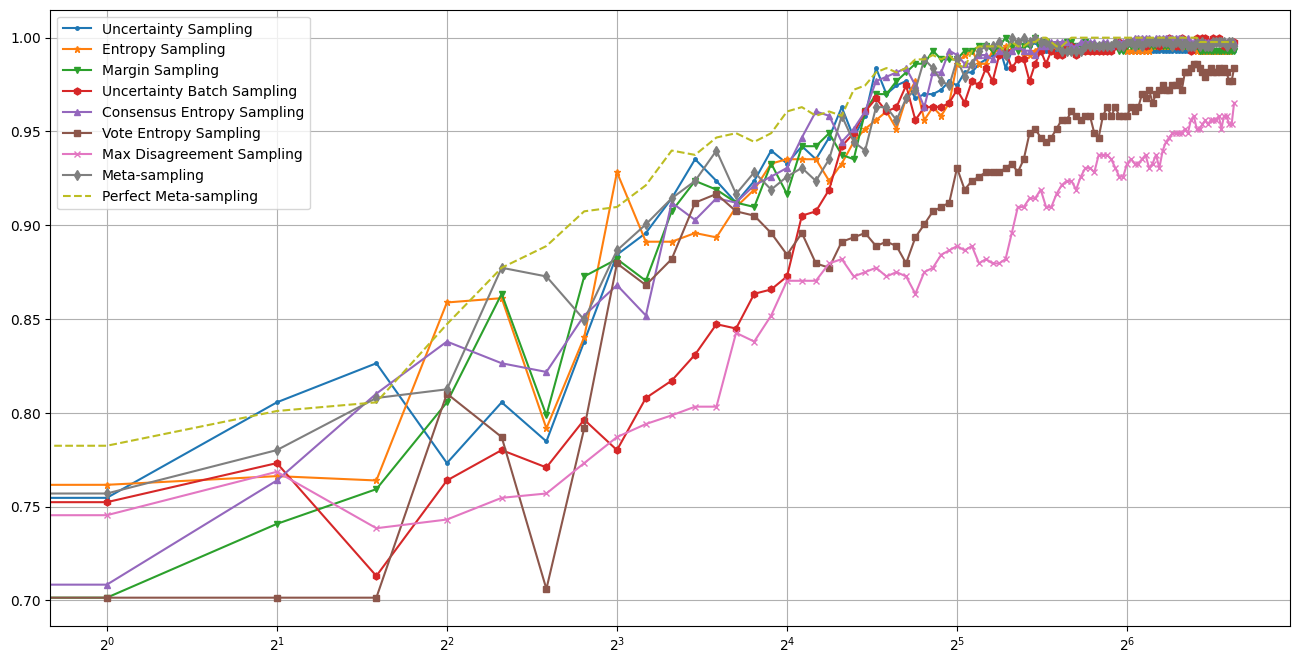

In [86]:
ax = pd.DataFrame(metrics_dict).plot(grid=True, style=styles, markersize=5, figsize=(16,8))
ax.set_xscale('log', base=2)